In [1]:
import pandas as pd
import json
import csv
import os
import numpy as np
import csv
import pprint

In [2]:
import string
import re

In [3]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [4]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

In [3]:
# preliminary data cleaning
with open("russia.csv") as all_tweets_csv:
    tweets_df = pd.read_csv(all_tweets_csv, low_memory=False)
    
# select only English tweets
english_tweets_df = tweets_df[tweets_df['language'] == 'English']

# sentiment data to csv
english_tweets_df.to_csv("russia_with_sentiments.csv", index=False)
with open("russia_with_sentiments.csv") as all_tweets_csv:
    tweets_df = pd.read_csv(all_tweets_csv, low_memory=False)
    
# date selection
tweets_df['publish_date'] = tweets_df['publish_date'].astype('datetime64[ns]')
mask = (tweets_df['publish_date'] > '2016-10-20') & (tweets_df['publish_date'] <= '2016-11-2')
tweets_df_bydate = tweets_df.loc[mask]

# Overall Analysis: Sentiment, Topic Modeling, % retweets, with links, etc.

This notebook serves to do general analysis of the IRA tweets. First starting with sentiment analysis using the tweet module of Python, topic modeling using Latent Dirichlet Allocation Modeling, and a general breakdown of the types of tweets in the corpus.

## 1. Sentiment Analysis

In [10]:
tweets_df_bydate.to_csv("russia_english_sentiments_dates.csv", index=False)

NameError: name 'tweets_df_bydate' is not defined

In [63]:
def get_tweet_sentiment(text, sentiment_type):
    sentiment_dict = sid_obj.polarity_scores(text)
    return sentiment_dict[sentiment_type]

In [64]:
sid_obj = SentimentIntensityAnalyzer()

In [70]:
sentiment_types = ['neg', 'neu', 'compound']
for sentiment_type in sentiment_types:
    name = 'sentiment_' + sentiment_type
    tweets_df_bydate[name] = tweets_df_bydate['content'].apply(lambda x: get_tweet_sentiment(str(x), sentiment_type))

### Analysis

In [5]:
with open("russia_english_sentiments_dates.csv") as file:
    tweets_df_bydate = pd.read_csv(file) 

In [30]:
sentiment_plot_df = tweets_df_bydate[['publish_date','account_category', 'sentiment_pos',
       'sentiment_neg', 'sentiment_neu', 'sentiment_compound']]

In [31]:
sentiment_plot_df['publish_date'] = pd.to_datetime(sentiment_plot_df['publish_date'])

<ipython-input-31-e756c12bca6b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sentiment_plot_df['publish_date'] = pd.to_datetime(sentiment_plot_df['publish_date'])


In [33]:
sentiment_plot_df = sentiment_plot_df.set_index('publish_date')

In [34]:
sentiment_plot_df

,account_category,sentiment_pos,sentiment_neg,sentiment_neu,sentiment_compound
publish_date,,,,,
2016-10-20 00:17:00,NewsFeed,0.000,0.206,0.794,-0.5994
2016-10-20 00:35:00,NewsFeed,0.000,0.161,0.839,-0.3182
2016-10-20 00:40:00,NewsFeed,0.000,0.000,1.000,0.0000
2016-10-20 00:48:00,NewsFeed,0.093,0.252,0.654,-0.5267
2016-10-20 11:10:00,NewsFeed,0.162,0.325,0.513,-0.4404
...,...,...,...,...,...
2016-11-01 06:37:00,NewsFeed,0.000,0.294,0.706,-0.3612
2016-10-22 12:32:00,LeftTroll,0.033,0.485,0.482,-0.9517
2016-10-22 12:33:00,LeftTroll,0.200,0.436,0.364,-0.3818


array([<matplotlib.axes._subplots.AxesSubplot object at 0x11aaf8370>,
      dtype=object)

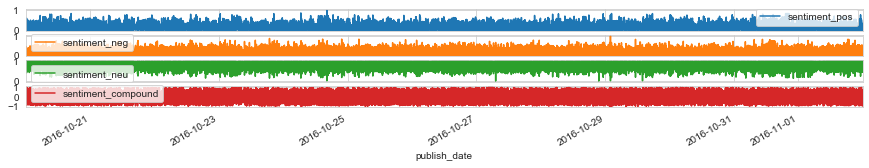

In [35]:
sentiment_plot_df.plot(subplots=True, figsize=(15,2))

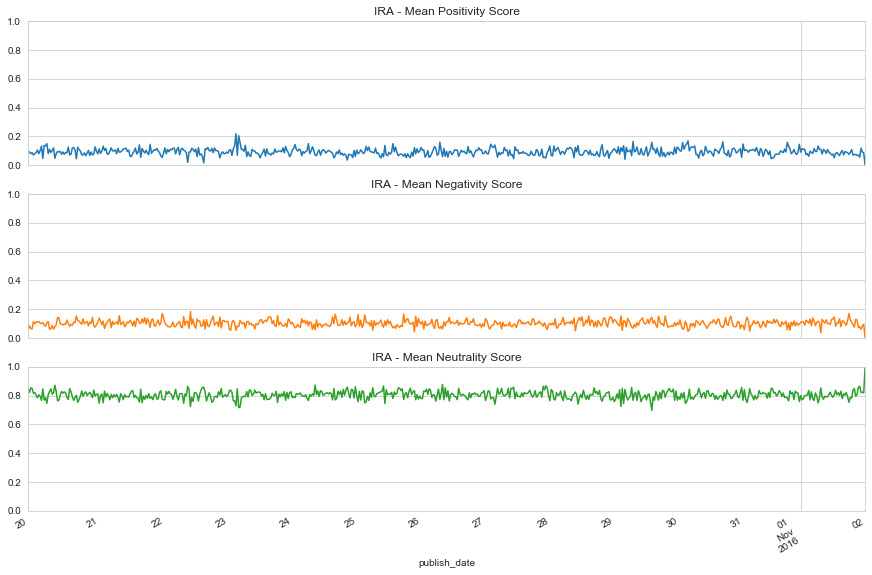

In [51]:
median_by_time = sentiment_plot_df[['sentiment_pos', 'sentiment_neg', 'sentiment_neu']].resample("30T").mean().plot(subplots=True, figsize=(15,10), ylim = (0.0, 1.0), title = ["IRA - Mean Positivity Score", 'IRA - Mean Negativity Score', 'IRA - Mean Neutrality Score'], legend=False)



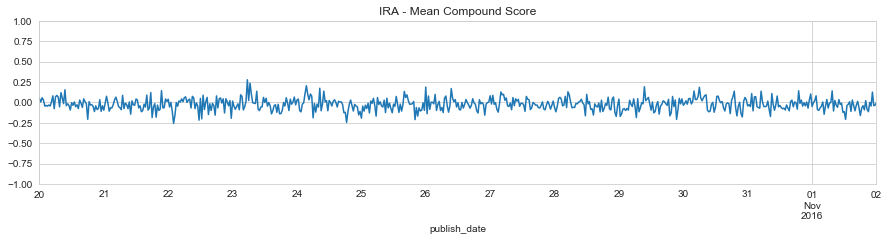

In [50]:
median_by_time = sentiment_plot_df[['sentiment_compound']].resample("30T").mean().plot(figsize=(15,3), ylim = (-1.0, 1.0), title = "IRA - Mean Compound Score", legend=False)


In [152]:
sentiment_plot_df.groupby(['account_category']).mean()

,sentiment_pos,sentiment_neg,sentiment_neu,sentiment_compound
account_category,,,,
HashtagGamer,0.080633,0.092770,0.826597,-0.011011
LeftTroll,0.110205,0.084980,0.804673,0.037783
NewsFeed,0.061932,0.140272,0.797799,-0.143115
NonEnglish,0.106242,0.089926,0.803844,0.014019
RightTroll,0.091839,0.096384,0.811774,-0.016530


In [151]:
sentiment_plot_df.groupby(['account_category']).median()

,sentiment_pos,sentiment_neg,sentiment_neu,sentiment_compound
account_category,,,,
HashtagGamer,0.0,0.0,0.8730,0.0
LeftTroll,0.0,0.0,0.8160,0.0
NewsFeed,0.0,0.0,0.7920,0.0
NonEnglish,0.0,0.0,0.8245,0.0
RightTroll,0.0,0.0,0.8190,0.0


In [153]:
sentiment_plot_df.groupby(pd.Grouper(freq='D')).median()

,sentiment_pos,sentiment_neg,sentiment_neu,sentiment_compound
publish_date,,,,
2016-10-20,0.0,0.0,0.814,0.0
2016-10-21,0.0,0.0,0.796,0.0
2016-10-22,0.0,0.0,0.808,0.0
2016-10-23,0.0,0.0,0.811,0.0
2016-10-24,0.0,0.0,0.832,0.0
2016-10-25,0.0,0.0,0.822,0.0
2016-10-26,0.0,0.0,0.806,0.0
2016-10-27,0.0,0.0,0.813,0.0
2016-10-28,0.0,0.0,0.806,0.0


In [5]:
sentiment_plot_df.groupby(pd.Grouper(freq='D')).median()

NameError: name 'sentiment_plot_df' is not defined

## 2. Topic Modeling

In [6]:
tweets_df_bydate.columns

Index(['external_author_id', 'author', 'content', 'region', 'language',
       'publish_date', 'harvested_date', 'following', 'followers', 'updates',
       'post_type', 'account_type', 'retweet', 'account_category',
       'new_june_2018', 'alt_external_id', 'tweet_id', 'article_url',
       'tco1_step1', 'tco2_step1', 'tco3_step1', 'sentiment_pos',
       'sentiment_neg', 'sentiment_neu', 'sentiment_compound'],
      dtype='object')

In [7]:
tweets_df_bydate['content_processed'] = tweets_df_bydate['content'].apply(lambda x: re.sub(r"http\S+", "", str(x)))
tweets_df_bydate['content_processed'] = tweets_df_bydate['content_processed'].apply(lambda x: ' '.join(word.strip(string.punctuation) for word in x.split()))
tweets_df_bydate['content_processed'] = tweets_df_bydate['content_processed'].apply(lambda x: x.lower())


In [8]:
tweets_df_bydate['content_processed'].head()

0    authorities say a sheriff’s deputy in a northe...
1    unr freshman from concord in critical conditio...
2        preteens need only 2 hpv shots not 3 cdc says
3    santa clara county board votes to suspend busi...
4    indiana official clarifies voter registration ...
Name: content_processed, dtype: object

In [9]:
def plot_10_most_common_words(count_data, count_vectorizer, title):
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='10 most common words of ' + title)
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation = 45, ha = 'right') 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()

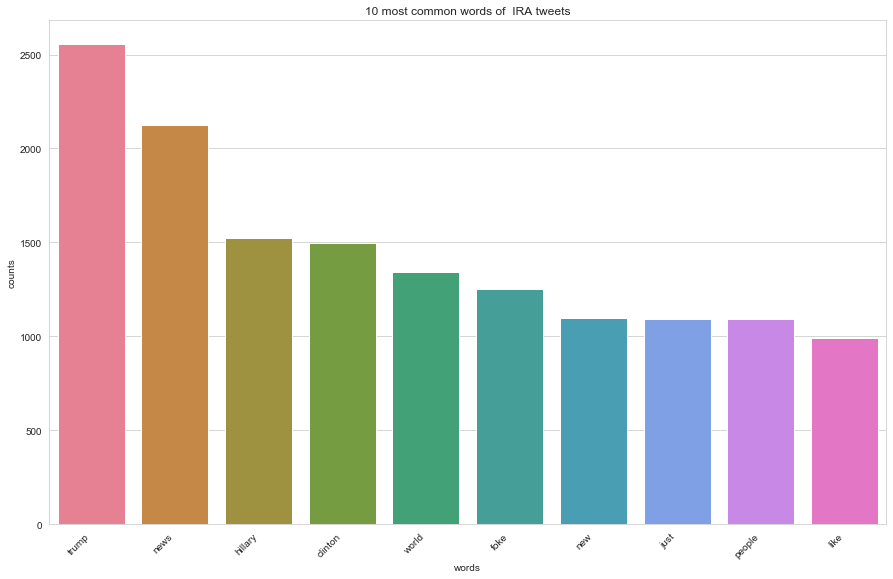

In [10]:
count_vectorizer = CountVectorizer(stop_words='english')
count_data = count_vectorizer.fit_transform(tweets_df_bydate['content_processed'])
plot_10_most_common_words(count_data, count_vectorizer, " IRA tweets")

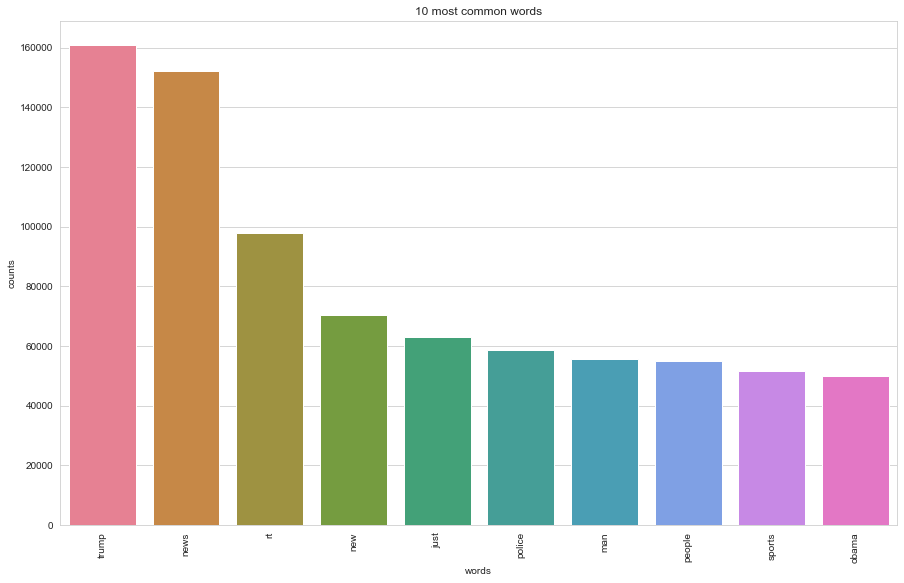

In [70]:
count_vectorizer = CountVectorizer(stop_words='english')
count_data = count_vectorizer.fit_transform(tweets_df['content_processed'])
plot_10_most_common_words(count_data, count_vectorizer)

In [137]:
import warnings
warnings.simplefilter("ignore", DeprecationWarning)
# Load the LDA model from sk-learn
from sklearn.decomposition import LatentDirichletAllocation as LDA
 
# Helper function
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        
# Tweak the two parameters below
number_topics = 5
number_words = 10
# Create and fit the LDA model
lda = LDA(n_components=number_topics, n_jobs=-1)
lda.fit(count_data)
# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda, count_vectorizer, number_words)

Topics found via LDA:

Topic #0:
news world new time just says thingsthatdisturbme 2016 clinton state

Topic #1:
imtoooldfor like nowplaying music love don right halloween god idontneedacostumebecause

Topic #2:
police man news black people new just nodapl killed shot

Topic #3:
foke fbi clinton emails cubs world new series trump halloween

Topic #4:
trump hillary clinton people vote like donald don election debate


In [71]:
import warnings
warnings.simplefilter("ignore", DeprecationWarning)
# Load the LDA model from sk-learn
from sklearn.decomposition import LatentDirichletAllocation as LDA
 
# Helper function
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        
# Tweak the two parameters below
number_topics = 5
number_words = 10
# Create and fit the LDA model
lda = LDA(n_components=number_topics, n_jobs=-1)
lda.fit(count_data)
# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda, count_vectorizer, number_words)

Topics found via LDA:

Topic #0:
obama trump new tcot amp video president russia breaking clinton

Topic #1:
rt trump white just realdonaldtrump media obama president amp potus

Topic #2:
news police man world local killed woman shooting state new

Topic #3:
like don people just black know need make love want

Topic #4:
sports trump politics clinton news hillary new vote donald win


## 3. Breakdown of Types of Tweets

In [150]:
len(tweets_df_bydate.index)

33620

In [140]:
len(tweets_df_bydate[tweets_df_bydate['account_category'] == 'NewsFeed'].index)

8329

In [141]:
len(tweets_df_bydate[tweets_df_bydate['account_category'] == 'RightTroll'].index)

7065

In [142]:
len(tweets_df_bydate[tweets_df_bydate['account_category'] == 'LeftTroll'].index)

14048

In [143]:
len(tweets_df_bydate[tweets_df_bydate['account_category'] == 'Fearmonger'].index)

0

In [144]:
len(tweets_df_bydate[tweets_df_bydate['account_category'] == 'HashtagGamer'].index)

2278

In [149]:
len(tweets_df_bydate[tweets_df_bydate['account_category'] == 'NonEnglish'].index)

1900

In [138]:
len(tweets_df_bydate[tweets_df_bydate['retweet'] == 1].index)

23063